Для начала введем константы для работы с нашим датасетом

In [1]:
DATASET_PATH = r"C:\Users\geize\Downloads\data\extracted_images"

In [16]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Проверим доступные нам папки в датасете

In [3]:
print(os.listdir(DATASET_PATH))

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'alpha', 'ascii_124', 'b', 'beta', 'C', 'cos', 'd', 'Delta', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'G', 'gamma', 'geq', 'gt', 'H', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'M', 'mu', 'N', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'R', 'rightarrow', 'S', 'sigma', 'sin', 'sqrt', 'sum', 'T', 'tan', 'theta', 'times', 'u', 'v', 'w', 'X', 'y', 'z', '[', ']', '{', '}']


Нам понадобиться метод, который будет возвращать массив папок из корневой директории датасета

In [4]:
def get_dataset_directories() -> list[str]:
    return os.listdir(DATASET_PATH)

In [5]:
def load_and_preprocess_image(image_path):    
    image = cv2.imread(image_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return gray_image.flatten()

In [6]:
def get_dataset():
    X, Y = [], []
        
    for dir_name in get_dataset_directories():
        dir = os.listdir(DATASET_PATH + f"/{dir_name}")
        
        for file in dir:
            path = os.path.join(DATASET_PATH, dir_name, file)
            X.append(load_and_preprocess_image(str(path)))
            Y.append(dir_name)
    
    return X, Y

In [8]:
X, y = get_dataset()

pixel_columns = [f"pixel_{i+1}" for i in range(len(X[0]))]
df_pixels = pd.DataFrame(X, columns=pixel_columns)

df_pixels['label'] = y

df_pixels.to_csv('dataset.csv', index=False)

df_pixels.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_2017,pixel_2018,pixel_2019,pixel_2020,pixel_2021,pixel_2022,pixel_2023,pixel_2024,pixel_2025,label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,!
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,!
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,!
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,!
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,!


Загрузим датасет из полученного csv файла

In [3]:
df = pd.read_csv('dataset.csv')

X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy().astype(str)

X

C:\Users\geize\AppData\Local\Temp\ipykernel_16868\3290691412.py:1: DtypeWarning: Columns (2025) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(375974, 2025))

Необходимо понять как выглядит распределение меток в датасете

Распределение меток:
label
-         33997
X         26594
1         26520
2         26141
+         25112
          ...  
Delta       137
lambda      109
in           47
forall       45
exists       21
Name: count, Length: 84, dtype: int64


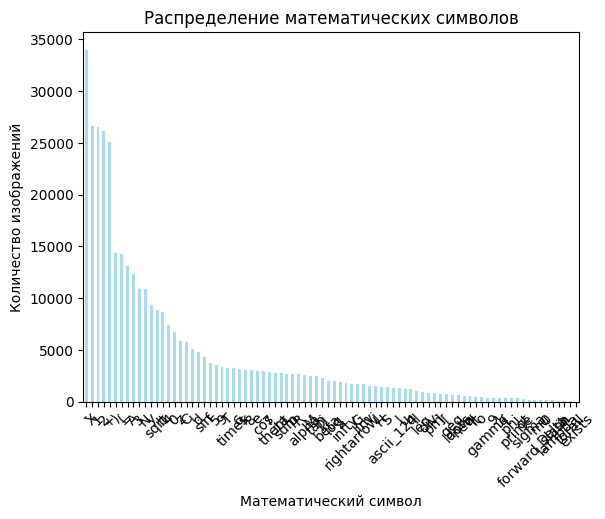

In [4]:
label_counts = df['label'].value_counts()

print("Распределение меток:")
print(label_counts)

label_counts.plot(kind='bar', alpha=0.7, color='skyblue')
plt.title("Распределение математических символов")
plt.xlabel("Математический символ")
plt.ylabel("Количество изображений")
plt.xticks(rotation=45)
plt.show()

Проверим есть ли пустые метки в датасете:

In [5]:
print("Распределение меток:")
print(label_counts.to_dict())

print("Пустых меток:")
print(df['label'].isnull().sum())


Распределение меток:
{'-': 33997, 'X': 26594, 1: 26520, 2: 26141, '+': 25112, ')': 14355, '(': 14294, '=': 13104, 'A': 12367, 3: 10909, 'N': 10862, 'y': 9340, 'sqrt': 8908, 'b': 8651, 4: 7396, 0: 6742, 'z': 5870, 'C': 5802, 'i': 5140, 'd': 4852, 'sin': 4293, 'f': 3712, 5: 3545, 9: 3348, 'T': 3274, 'times': 3251, 6: 3118, 'k': 3074, 8: 3068, 'e': 3003, 'cos': 2986, 7: 2909, 'theta': 2796, 'int': 2742, 'sum': 2689, 'p': 2680, 'R': 2671, 'alpha': 2546, 'M': 2476, 'tan': 2450, 'pi': 2332, 'beta': 2025, 'log': 2001, ',': 1906, 'infty': 1783, 'rightarrow': 1703, 'G': 1692, 'lim': 1675, 'v': 1558, 'j': 1536, 'H': 1464, 'S': 1413, 'ascii_124': 1339, '!': 1300, 'u': 1269, 'q': 1230, 'l': 1017, 'leq': 973, 'div': 868, 'pm': 802, ']': 780, '[': 778, 'geq': 693, 'ldots': 609, 'neq': 558, 'w': 556, 'lt': 477, 'o': 449, 'gamma': 409, '9': 389, '}': 377, '{': 376, 'phi': 355, 'prime': 329, 'gt': 258, 'sigma': 201, 'forward_slash': 199, 'mu': 177, '0': 172, 'Delta': 137, 'lambda': 109, 'in': 47, 'fora

Нам повезло и наш датасет не содержит пустых меток, однако, как мы видим, распределение классов в датасете совсем не сбалансированно, что будет крайне плохо в нашем случае, когда мы собираемся использовать Наивного Байоса.

In [6]:
y

array(['!', '!', '!', ..., '}', '}', '}'], shape=(375974,), dtype='<U13')

Поробуем сократить размерность используя функционал PCA. Для начала стандартизируем данные:

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

SyntaxError: invalid syntax (285935828.py, line 1)

Попробуем высчитать сколько компонент нужно для PCA, чтобы покрыть 95% дисперсии:

In [ ]:
pca = PCA()
pca.fit(X_scaled)

# Вывод доли объяснённой дисперсии
explained_variance = pca.explained_variance_ratio_
print("Доля объяснённой дисперсии:", explained_variance)

# Нахождение минимального числа компонент для 95% дисперсии
cum_sum = np.cumsum(explained_variance)
n_components = np.argmax(cum_sum >= 0.95) + 1  # +1, потому что индексация с 0
print(f"Для 95% дисперсии достаточно {n_components} компонент.")

После применим сам функционал PCA:

In [ ]:
pca = PCA(n_components=n_components)
X = pca.fit_transform(X_scaled)

Для того, чтобы преставить категориальные таргеты как числовые мы прибегнем к способу one_hot_encoding

In [7]:
encoder = OneHotEncoder(sparse_output=False)

y_encoded = encoder.fit_transform(y.reshape(-1, 1))

print("Исходные символы:")
print(y)
print("\nOne-hot encoded символы:")
print(y_encoded)

df_encoded = pd.DataFrame(y_encoded, columns=encoder.get_feature_names_out())
df_encoded['Symbol'] = y

print("\nDataFrame с символами и их one-hot кодами:")
print(df_encoded)
print(y_encoded)

Исходные символы:
['!' '!' '!' ... '}' '}' '}']

One-hot encoded символы:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

DataFrame с символами и их one-hot кодами:
        x0_!  x0_(  x0_)  x0_+  x0_,  x0_-  x0_0  x0_1  x0_2  x0_3  ...  \
0        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
375969   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
375970   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
375971   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Попробуем провести баланс распределения воспользовавшись методом SMOT

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# 
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# 
# print(f"До SMOTE: {y_train.value_counts()}")
# print(f"После SMOTE: {y_resampled.value_counts()}")

MemoryError: 

Метод SMOT съел все память, поэтому прийдется пробовать что-то другое. Например мы можем воспользоваться весами, чтобы класс, которого меньше всего по важности был равен тому, которого больше всего

In [8]:
classes = np.unique(y)

class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, class_weights))

class_weights_dict

{np.str_('!'): np.float64(3.5269606003752347),
 np.str_('('): np.float64(0.3207673695598017),
 np.str_(')'): np.float64(0.31940430376090595),
 np.str_('+'): np.float64(0.18258397501146084),
 np.str_(','): np.float64(2.4055869782202546),
 np.str_('-'): np.float64(0.1348662758622174),
 np.str_('0'): np.float64(0.6631542928099226),
 np.str_('1'): np.float64(0.17289022550858993),
 np.str_('2'): np.float64(0.17539683946627155),
 np.str_('3'): np.float64(0.42029964070838804),
 np.str_('4'): np.float64(0.6199362872482159),
 np.str_('5'): np.float64(1.2933847053562213),
 np.str_('6'): np.float64(1.4705095511506752),
 np.str_('7'): np.float64(1.576159773285598),
 np.str_('8'): np.float64(1.4944748306674722),
 np.str_('9'): np.float64(1.2269330426780318),
 np.str_('='): np.float64(0.3498968849578606),
 np.str_('A'): np.float64(0.37074866826941094),
 np.str_('C'): np.float64(0.7902531507217865),
 np.str_('Delta'): np.float64(33.467509346626315),
 np.str_('G'): np.float64(2.7098397047800264),
 np.

Разобьем датасет на обучающую и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Можем попробовать обучить модель на исходных данных с такими весами

In [10]:
class_prior = np.array([class_weights_dict[cls] for cls in classes])

class_prior = class_prior / np.sum(class_prior)

print(class_prior)

[4.33349463e-03 3.94119422e-04 3.92444655e-04 2.24336692e-04
 2.95568889e-03 1.65707063e-04 8.14802288e-04 2.12426207e-04
 2.15506026e-04 5.16412413e-04 7.61701328e-04 1.58915177e-03
 1.80678096e-03 1.93659093e-03 1.83622654e-03 1.50750415e-03
 4.29910182e-04 4.55530284e-04 9.70965705e-04 4.11207520e-02
 3.32951715e-03 3.84804851e-03 2.27525970e-03 5.18646936e-04
 2.10915126e-03 3.98693773e-03 1.72069121e-03 2.11835114e-04
 7.24105786e-03 7.22249105e-03 2.21270346e-03 4.20727634e-03
 6.51201366e-04 2.78199655e-03 1.88665205e-03 1.16107647e-03
 6.49025693e-03 1.87597170e-03 2.68263953e-01 1.51765706e-03
 1.25189845e-01 2.83092614e-02 1.37739438e-02 8.12921070e-03
 2.18354381e-02 1.09602004e-03 1.19862617e-01 3.15958666e-03
 2.05453794e-03 3.66767124e-03 1.83264249e-03 5.53937367e-03
 5.16838809e-02 9.25048115e-03 5.78986949e-03 3.36330926e-03
 2.81536383e-03 1.18103627e-02 3.18279267e-02 1.00959552e-02
 1.25468664e-02 2.10206829e-03 1.58691353e-02 2.41575601e-03
 7.02436785e-03 1.712323

In [11]:
model = MultinomialNB(class_prior=class_prior)
# model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(class_prior=array([4.33349463e-03, 3.94119422e-04, 3.92444655e-04, 2.24336692e-04,
       2.95568889e-03, 1.65707063e-04, 8.14802288e-04, 2.12426207e-04,
       2.15506026e-04, 5.16412413e-04, 7.61701328e-04, 1.58915177e-03,
       1.80678096e-03, 1.93659093e-03, 1.83622654e-03, 1.50750415e-03,
       4.29910182e-04, 4.55530284e-04, 9.70965705e-04, 4.11207520e-02,
       3.32951715e-03, 3....
       2.81536383e-03, 1.18103627e-02, 3.18279267e-02, 1.00959552e-02,
       1.25468664e-02, 2.10206829e-03, 1.58691353e-02, 2.41575601e-03,
       7.02436785e-03, 1.71232311e-02, 4.58011628e-03, 3.30801117e-03,
       2.80275772e-02, 1.31226252e-03, 6.32413900e-04, 2.09503273e-03,
       2.29940531e-03, 2.01485802e-03, 1.73286466e-03, 4.43935620e-03,
       3.61588127e-03, 1.01322716e-02, 6.03163064e-04, 9.59717720e-04,
       1.49828272e-02, 1.49430849e-02]))

Оценим полученую модель на выбранных для данного проекта метриках

In [13]:
y_pred = model.predict(X_test)

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Макро-усредненный Precision: {precision_macro:.4f}")
print(f"Макро-усредненный Recall: {recall_macro:.4f}")
print(f"Макро-усредненный F1: {f1_macro:.4f}")

Макро-усредненный Precision: 0.3804
Макро-усредненный Recall: 0.5368
Макро-усредненный F1: 0.3956


Сохраним веса обученной модели

In [14]:
joblib.dump(model, 'multinomial_nb_model_with_stratify.pkl')

print("Модель сохранена в файл 'multinomial_nb_model.pkl'")

Модель сохранена в файл 'multinomial_nb_model.pkl'


Наивный Байос дяже при учете всех обработок нашего датасета не дал хорошей оценки. Попробуем восопользоваться методом опорных векторов:


In [17]:
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

model.fit(X_train, y_train)

SVC(random_state=42)

Оценим полученную модель:

In [ ]:
y_pred = model.predict(X_test)

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Макро-усредненный Precision: {precision_macro:.4f}")
print(f"Макро-усредненный Recall: {recall_macro:.4f}")
print(f"Макро-усредненный F1: {f1_macro:.4f}")

Сохраним обученную модель

In [ ]:
joblib.dump(model, 'svc_model.pkl')

print("Модель сохранена в файл 'multinomial_nb_model.pkl'")